# LGBM을 활용한 베이스라인

In [3]:
import pandas as pd
import os
import random
from math import log10 as log
import seaborn as sns
import matplotlib.pyplot as plt
import time
from datetime import datetime
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.decomposition import PCA
import numpy as np

## 1. 데이터 로딩

In [4]:
data_dir = '/opt/ml/input/data/'
csv_file_path = os.path.join(data_dir, 'train_data.csv')
df = pd.read_csv(csv_file_path) 

## 2. Feature Engineering

In [5]:
def fe(df):
    
    #유저별 시퀀스를 고려하기 위해 아래와 같이 정렬
    df.sort_values(by=['userID','Timestamp'], inplace=True)
    
    #유저들의 문제 풀이수, 정답 수, 정답률을 시간순으로 누적해서 계산
    df['user_correct_answer'] = df.groupby('userID')['answerCode'].transform(lambda x: x.cumsum().shift(1))
    df['user_total_answer'] = df.groupby('userID')['answerCode'].cumcount()
    df['user_acc'] = df['user_correct_answer']/df['user_total_answer']

    # testId와 KnowledgeTag의 전체 정답률은 한번에 계산
    # 아래 데이터는 제출용 데이터셋에 대해서도 재사용
    correct_t = df.groupby(['testId'])['answerCode'].agg(['mean', 'sum'])
    correct_t.columns = ["test_mean", 'test_sum']
    correct_k = df.groupby(['KnowledgeTag'])['answerCode'].agg(['mean', 'sum'])
    correct_k.columns = ["tag_mean", 'tag_sum']

    df = pd.merge(df, correct_t, on=['testId'], how="left")
    df = pd.merge(df, correct_k, on=['KnowledgeTag'], how="left")
    
    
    return df

In [6]:
def convert_time2timestamp(t):
    timestamp = time.mktime(t.timetuple())
    return int(timestamp)

def convert_string2datetime(s: str):
    return datetime.strptime(s, "%Y-%m-%d %H:%M:%S")

def time_stamp_fe(df):
    ## 문자열로 인식되는 Timestamp의 타입을 datetime으로 변경하기. 
    print('Timestamp feature engineering start ..',end='')
    df["Timestamp"] = df["Timestamp"].apply(convert_string2datetime) # string type to datetime type


    ## 기본적인 시간정보 추가
    df['year'] = df['Timestamp'].dt.year
    df['month'] = df['Timestamp'].dt.month
    df['day'] = df['Timestamp'].dt.day
    df['hour'] = df['Timestamp'].dt.hour                                       # 시간대로 범주 추가 가능


    ## 요일 추가
    df['wday'] = df['Timestamp'].dt.weekday # Monday ~ Sunday => 0 ~ 6         # 주말로 범주 추가 가능
    

    ## 문제를 다시 풀어본 횟수 feature 'retry' 추가
    test_group = df.groupby(['userID','testId']) # 같은 시험지끼리 묶어준다.
    # retry_check = 0
    retry_df = pd.DataFrame()
    for key, group in test_group:
        if len(group[group.assessmentItemID == group.assessmentItemID.iloc[0]]) >= 2:
            retry_df = pd.concat([retry_df,group.groupby('assessmentItemID').cumcount()])
            # retry_check += 1
    retry_df.columns=['retry']
    df = pd.merge(df, retry_df, left_index=True,right_index=True, how="left")
    df['retry'] = df['retry'].fillna(0) # retry의 결측치(한 번만 푼 문제들)을 0으로 바꿔준다.

    
    ## 문제 풀이 시간 추가
    df['time'] = df['time'] = df.groupby(['userID','testId','retry'])['Timestamp'].diff().shift(-1) # 문제 풀이 시간
    df['time'] = df['time'].fillna(df['time'].median())                        # Null값은 중앙값으로 채우기.
    df['time'] = df['time'].apply(lambda x:x.total_seconds())                  # 년,월,일,날짜로 되어있는 값을 시간초로 변환
    df['time'] = df['time'].apply(lambda x:300 if x > 300 else x)              # 최댓값을 300으로 변환.


    ## 문제 풀이 시간 그룹 추가
    time_ranges = [-0.001,5,18,27,37,80,300]
    df['time_class'] = pd.cut(df['time'],time_ranges,labels=[0,1,2,3,4,5])
    
    ## 문제 풀이 시간 그룹별 통계량 추가
    time_class_stat = df[df['userID'].shift(1) == df['userID']].groupby(['time_class'])['answerCode'].agg(['mean','sum','std'])
    time_class_stat.columns = ['time_class_mean', 'time_class_sum', 'time_class_std']
    df = pd.merge(df,time_class_stat,on=['time_class'],how='left')


    ## 전체적인 시간정보를 나타내는 Timestamp는 int형으로 변환.
    df["Timestamp"] = df["Timestamp"].apply(convert_time2timestamp) # datetime to timestamp
    print(' Done.')

    return df

In [7]:
def test_fe(df):
    print('TestID feature engineering start ..',end='')
    ## 시험지의 평균 정답률, 정답 개수, 표준편차
    correct_t = df[df['userID'].shift(1) == df['userID']].groupby(['testId'])['answerCode'].agg(['mean', 'sum','std'])
    correct_t.columns = ["test_ans_mean", 'test_ans_sum','test_ans_std']
    df = pd.merge(df, correct_t, on=['testId'], how="left")

    ## 시험지의 평균 풀이 시간, 표준편차
    time_t = df.groupby(['testId'])['time'].agg(['mean', 'std'])
    time_t.columns = ["test_time_mean", 'test_time_std']
    df = pd.merge(df, time_t, on=['testId'], how="left")


    ## 시험지 대분류(test_type) 생성
    df['test_type'] = df['testId'].apply(lambda x:int(x[2]))

    ## 시험지 대분류별 정답률, 정답 개수, 표준편차
    correct_type = df[df['userID'].shift(1) == df['userID']].groupby(['test_type'])['answerCode'].agg(['mean', 'sum','std'])
    correct_type.columns = ["t_type_ans_mean", 't_type_ans_sum','t_type_ans_std']
    df = pd.merge(df, correct_type, on=['test_type'], how="left")

    ## 시험지 대분류별 풀이시간, 표준편차
    time_type = df.groupby(['test_type'])['time'].agg(['mean', 'std'])
    time_type.columns = ["t_type_time_mean", 't_type_time_std']
    df = pd.merge(df, time_type, on=['test_type'], how="left")

    ## 시험지 난이도
    df['test_lvl'] = df['test_time_mean'] / df['test_ans_mean']
    # 범주화
    cat_num = 10
    df['test_lvl_cat'] = pd.qcut(df['test_lvl'],cat_num,labels=[i for i in range(cat_num)])

    ## 시험지 대분류별 난이도
    # 난이도를 나타내는 척도는 임의로 풀이시간 평균 / 평균 정답률로 설정.
    # 풀이시간이 길어지면 난이도가 높아지고, 정답률이 낮아지면 난이도가 높아진다.
    df['test_type_lvl'] = df['t_type_time_mean'] / df['t_type_ans_mean']

    # 범주화
    type_cat_num = 3
    df['test_type_lvl_cat'] = pd.qcut(df['test_type_lvl'],type_cat_num,labels=[i for i in range(type_cat_num)])

    ## 시험지 노출 횟수
    df['test_total_answer'] = df.groupby('testId')['answerCode'].cumcount()
    print(' Done.')

    return df

In [8]:
def elo_fe(K,df):
    ### ELO
    problems = df.assessmentItemID.unique()
    students = df.userID.unique()

    # rate는 4000으로 시작.
    problem_rate = {problem:4000 for problem in problems}
    student_rate = {student:4000 for student in students}
    elo_df = df[['userID', 'assessmentItemID', 'answerCode']]

    # ELO Rating function
    def win_rate(p_op, p_me): # 문제를 풀었을 때 얻는 rating 점수
        return 1/(10**((p_op-p_me)/100)+1) 

    def changed_score(K, p_op, p_me, result):
        '''
        params
            - K : Rating 변경 비율
            - p_op : assessmentID (문제)
            - p_me : UserID (사용자)
            - result : answerCode (문제 정오답 여부)
        variable
            - game_percent : 풀이로부터 변경되는 Rating 값.
            - next_op : 문제의 갱신된 Rating
            - next_me : User의 갱신된 Rating
        '''
        game_pecent = win_rate(p_op, p_me)
        next_op = p_op + K*(result - game_pecent)
        next_me = p_me - K*(result + game_pecent)
        return next_op, next_me

    # 하나의 row는 하나의 경기인 셈.
    for i in range(elo_df.shape[0]):
        op, me, result = elo_df.iloc[i]
        student_rate[op], problem_rate[me] = changed_score(K,student_rate[op], problem_rate[me], result)

    problem_df = pd.DataFrame.from_dict(data=problem_rate, orient='index').rename(columns={0:'problem_rate'})
    student_df = pd.DataFrame.from_dict(data=student_rate, orient='index').rename(columns={0:'student_rate'})

    df['student_rate'] = df.userID.apply(lambda x:student_rate[x])
    df['problem_rate'] = df.assessmentItemID.apply(lambda x:problem_rate[x])
    df['log_student_rate'] = df.student_rate.apply(lambda x:log(x))

    def rate(arr):  # 수능 등급 기준과 동일하게 0.5시그마 기준으로 1~9등급 나누기. 단, 실력이 좋으면 9등급.
        m, std = arr.mean(), arr.std()
        tarr = 9 - (((arr - m) / std + 1.75) * 2).astype(int)
        return tarr.apply(lambda x : min(max(x,1), 9))

    #학생별로 문제를 푼 수가 달라서 학생만 모아둔 df를 따로 관리하여 추가
    problem_df['problem_grade'] = rate(problem_df['problem_rate'])
    student_df['student_grade'] = rate(student_df['student_rate'])
    df = pd.merge(df, problem_df, how='left', on='problem_rate')
    df = pd.merge(df, student_df, how='left', on='student_rate')

    return df

In [67]:
def tag_fe(df):
    print('TagID feature engineering start ..',end='')
    ## tag의 평균 정답률, 정답 총합, 표준편차
    correct_k = df[df['userID'].shift(1) == df['userID']].groupby(['KnowledgeTag'])['answerCode'].agg(['mean', 'sum','std'])
    correct_k.columns = ["tag_ans_mean", 'tag_ans_sum','tag_ans_std']
    df = pd.merge(df, correct_k, on=['KnowledgeTag'], how="left")
    
    ## 태그의 평균 풀이 시간, 표준편차
    time_k = df.groupby(['KnowledgeTag'])['time'].agg(['mean', 'std'])
    time_k.columns = ["tag_time_mean", 'tag_time_std']
    df = pd.merge(df, time_k, on=['KnowledgeTag'], how="left")

    ## 태그 난이도
    df['tag_lvl'] = df['tag_time_mean'] / df['tag_ans_mean']

    # 범주화
    tag_cat_num = 10
    df['tag_lvl_cat'] = pd.qcut(df['tag_lvl'],tag_cat_num,labels=[i for i in range(tag_cat_num)])

    ## 태그 노출 횟수
    df['tag_total_answer'] = df.groupby('KnowledgeTag')['answerCode'].cumcount()
    print(' Done.')
    return df

In [75]:
def user_fe(df):
    print('UserID feature engineering start ..',end='')
    #유저들의 문제 풀이수, 정답 수, 정답률을 시간순으로 누적해서 계산
    df['user_ans_1'] = df[df['userID'].shift(1) == df['userID']].groupby('userID')['answerCode'].transform(lambda x:x.cumsum().shift(1))
    df['user_total_ans'] = df.groupby('userID')['answerCode'].cumcount()
    df['user_acc'] = df['user_ans_1']/df['user_total_ans']

    df['user_test_ans_count'] = df.groupby(['userID','testId'])['answerCode'].cumcount()
    df['user_test_ans_1'] = df[df['userID'].shift(1) == df['userID']].groupby(['userID','testId'])['answerCode'].transform(lambda x:x.cumsum().shift(1))
    df['user_test_acc'] = df['user_test_ans_1'] / df['user_test_ans_count']
    df['user_test_lvl_mean'] = df.groupby(['userID'])['test_lvl'].cumsum() / (df.user_total_ans + 1)

    df['user_tag_ans_count'] = df.groupby(['userID','KnowledgeTag'])['answerCode'].cumcount()
    df['user_tag_ans_1'] = df[df['userID'].shift(1) == df['userID']].groupby(['userID','KnowledgeTag'])['answerCode'].transform(lambda x:x.cumsum().shift(1))
    df['user_tag_acc'] = df['user_tag_ans_1'] / df['user_tag_ans_count']
    df['user_tag_lvl_mean'] = df.groupby(['userID'])['tag_lvl'].cumsum() / (df.user_total_ans + 1)

    # df['user_lvl'] = df.user_tag_lvl_mean + df.user_test_lvl_mean


    df['item_ans_1'] = df[df['userID'].shift(1) == df['userID']].groupby('assessmentItemID')['answerCode'].transform(lambda x:x.cumsum().shift(1))
    df['item_total_ans'] = df.groupby('assessmentItemID')['answerCode'].cumcount()
    df['item_acc'] = df['item_ans_1']/df['item_total_ans']
    
    print(' Done.')
    return df

In [9]:
# df[df['userID'].shift(1) != df['userID']]
df.columns

Index(['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp',
       'KnowledgeTag'],
      dtype='object')

In [9]:
df = fe(df)

In [10]:
df.columns

Index(['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp',
       'KnowledgeTag'],
      dtype='object')

In [64]:
tdf = time_stamp_fe(df)

Timestamp feature engineering start .. Done.


In [11]:
tdf = pd.read_csv('./time_train.csv')

In [12]:
tdf.columns

Index(['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp',
       'KnowledgeTag', 'user_correct_answer', 'user_total_answer', 'user_acc',
       'test_mean', 'test_sum', 'tag_mean', 'tag_sum', 'year', 'month', 'day',
       'hour', 'wday', 'retry', 'time', 'time_class', 'time_class_mean',
       'time_class_sum', 'time_class_std'],
      dtype='object')

In [13]:
te_df = elo_fe(1,tdf)

In [38]:
te_df.columns

Index(['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp',
       'KnowledgeTag', 'user_correct_answer', 'user_total_answer', 'user_acc',
       'test_mean', 'test_sum', 'tag_mean', 'tag_sum', 'year', 'month', 'day',
       'hour', 'wday', 'retry', 'time', 'time_class', 'time_class_mean',
       'time_class_sum', 'time_class_std', 'student_rate', 'problem_rate',
       'log_student_rate', 'problem_grade', 'student_grade'],
      dtype='object')

In [57]:
tte_df = test_fe(te_df)

TestID feature engineering start .. Done.


In [68]:
ttte_df = tag_fe(tte_df)

TagID feature engineering start .. Done.


In [69]:
ttte_df.columns

Index(['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp',
       'KnowledgeTag', 'user_correct_answer', 'user_total_answer', 'user_acc',
       'test_mean', 'test_sum', 'tag_mean', 'tag_sum', 'year', 'month', 'day',
       'hour', 'wday', 'retry', 'time', 'time_class', 'time_class_mean',
       'time_class_sum', 'time_class_std', 'student_rate', 'problem_rate',
       'log_student_rate', 'problem_grade', 'student_grade', 'test_ans_mean',
       'test_ans_sum', 'test_ans_std', 'test_time_mean', 'test_time_std',
       'test_type', 't_type_ans_mean', 't_type_ans_sum', 't_type_ans_std',
       't_type_time_mean', 't_type_time_std', 'test_lvl', 'test_lvl_cat',
       'test_type_lvl', 'test_type_lvl_cat', 'test_total_answer',
       'tag_ans_mean', 'tag_ans_sum', 'tag_ans_std', 'tag_time_mean',
       'tag_time_std', 'tag_lvl', 'tag_lvl_cat', 'tag_total_answer'],
      dtype='object')

In [58]:
tte_df.columns

Index(['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp',
       'KnowledgeTag', 'user_correct_answer', 'user_total_answer', 'user_acc',
       'test_mean', 'test_sum', 'tag_mean', 'tag_sum', 'year', 'month', 'day',
       'hour', 'wday', 'retry', 'time', 'time_class', 'time_class_mean',
       'time_class_sum', 'time_class_std', 'student_rate', 'problem_rate',
       'log_student_rate', 'problem_grade', 'student_grade', 'test_ans_mean',
       'test_ans_sum', 'test_ans_std', 'test_time_mean', 'test_time_std',
       'test_type', 't_type_ans_mean', 't_type_ans_sum', 't_type_ans_std',
       't_type_time_mean', 't_type_time_std', 'test_lvl', 'test_lvl_cat',
       'test_type_lvl', 'test_type_lvl_cat', 'test_total_answer'],
      dtype='object')

In [76]:
uttte_df = user_fe(ttte_df)

UserID feature engineering start .. Done.


In [77]:
uttte_df.columns

Index(['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp',
       'KnowledgeTag', 'user_correct_answer', 'user_total_answer', 'user_acc',
       'test_mean', 'test_sum', 'tag_mean', 'tag_sum', 'year', 'month', 'day',
       'hour', 'wday', 'retry', 'time', 'time_class', 'time_class_mean',
       'time_class_sum', 'time_class_std', 'student_rate', 'problem_rate',
       'log_student_rate', 'problem_grade', 'student_grade', 'test_ans_mean',
       'test_ans_sum', 'test_ans_std', 'test_time_mean', 'test_time_std',
       'test_type', 't_type_ans_mean', 't_type_ans_sum', 't_type_ans_std',
       't_type_time_mean', 't_type_time_std', 'test_lvl', 'test_lvl_cat',
       'test_type_lvl', 'test_type_lvl_cat', 'test_total_answer',
       'tag_ans_mean', 'tag_ans_sum', 'tag_ans_std', 'tag_time_mean',
       'tag_time_std', 'tag_lvl', 'tag_lvl_cat', 'tag_total_answer',
       'user_ans_1', 'user_total_ans', 'user_test_ans_count',
       'user_test_ans_1', 'user_test_acc', 'user_tes

## 3. Train/Test 데이터 셋 분리

In [39]:
# train과 test 데이터셋은 사용자 별로 묶어서 분리를 해주어야함
def custom_train_test_split(df, ratio=0.7, split=True):
    random.seed(42)
    users = list(zip(df['userID'].value_counts().index, df['userID'].value_counts()))
    random.shuffle(users)
    
    max_train_data_len = ratio*len(df)
    sum_of_train_data = 0
    user_ids =[]

    for user_id, count in users:
        sum_of_train_data += count
        if max_train_data_len < sum_of_train_data:
            break
        user_ids.append(user_id)


    train = df[df['userID'].isin(user_ids)]
    test = df[df['userID'].isin(user_ids) == False]

    #test데이터셋은 각 유저의 마지막 interaction만 추출
    test = test[test['userID'] != test['userID'].shift(-1)]
    return train, test

In [91]:
# 유저별 분리
train, test = custom_train_test_split(uttte_df)

# 사용할 Feature 설정
FEATS = [
         'user_acc','KnowledgeTag','test_mean', 'test_sum', 'tag_mean', 'time', 'tag_sum', 'user_correct_answer', 'Timestamp', 'user_total_answer',
         'hour', 'day', 'wday', 'time_class_sum', 'time_class_mean','retry', 'time_class_std','month', 
         'student_rate', 'problem_rate', 'log_student_rate', 'problem_grade', 'student_grade',
         'test_ans_mean',
         'test_ans_sum', 
         'test_ans_std', 
         'test_time_mean', 
         'test_time_std',
         'test_type', 't_type_ans_mean', 't_type_ans_sum', 't_type_ans_std',
         't_type_time_mean', 't_type_time_std', 'test_lvl', 'test_lvl_cat',
         'test_type_lvl', 'test_type_lvl_cat', 'test_total_answer',
         'tag_ans_std', 'tag_time_mean',
       'tag_time_std', 'tag_lvl', 'tag_lvl_cat', 'tag_total_answer',
       'user_ans_1', 'user_total_ans', 'user_test_ans_count',
       'user_test_ans_1', 'user_test_acc', 'user_test_lvl_mean',
       'user_tag_ans_count', 'user_tag_ans_1', 'user_tag_acc',
       'user_tag_lvl_mean', 'item_ans_1', 'item_total_ans', 'item_acc'
       ]


# X, y 값 분리
y_train = train['answerCode']
train = train.drop(['answerCode'], axis=1)

y_test = test['answerCode']
test = test.drop(['answerCode'], axis=1)

In [127]:
selector = SelectKBest(score_func=f_classif, k=30)
train[FEATS] = train[FEATS].fillna(0)
test[FEATS] = test[FEATS].fillna(0)
train_selected = selector.fit_transform(train[FEATS],y_train)
test_selected = selector.fit_transform(test[FEATS],y_test)

train_selected.shape,test_selected.shape

/opt/conda/envs/gcn/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 5 13] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/conda/envs/gcn/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


((1586157, 30), (2007, 30))

In [128]:
# lgb_train = lgb.Dataset(train[FEATS], y_train)
# lgb_test = lgb.Dataset(test[FEATS], y_test)
lgb_train = lgb.Dataset(train_selected, y_train)
lgb_test = lgb.Dataset(test_selected, y_test)

## 4. 훈련 및 검증

In [129]:
params = {
        #   'bagging_freq': 1, 
        #   'verbosity': -1, 
          'num_iterations': 2000,
          # 'feature_pre_filter': False,
          'objective': 'binary', 
          # 'metric': 'binary_logloss',
        #   'boosting': 'gbdt',
          # 'bagging_fraction': 0.7, # 정확도 조금 올라감
          # 'feature_fraction': 0.5, # 올리니 떨어짐
          # 'lambda_l1': 3,
        #   'lambda_l2': 5,
          'learning_rate': 0.02, # 낮추니 떨어짐
          # 'max_depth': 8, # 추가하니 떨어짐
          # 'min_child_samples': 8,
          # 'num_leaves': 150, # 추가하니 떨어짐
          }
# params={'objective':'binary'}

In [130]:
model = lgb.train(
    params, 
    lgb_train,
    valid_sets=[lgb_train, lgb_test],
    verbose_eval=100,
    num_boost_round=500,
    early_stopping_rounds=100
)

# preds = model.predict(test[FEATS])
preds = model.predict(test_selected)
acc = accuracy_score(y_test, np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(y_test, preds)

print(f'VALID AUC : {auc} ACC : {acc}\n')

/opt/conda/envs/gcn/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/envs/gcn/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/envs/gcn/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 1039565, number of negative: 546592
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026864 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4164
[LightGBM] [Info] Number of data points in the train set: 1586157, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.655399 -> initscore=0.642855
[LightGBM] [Info] Start training from score 0.642855
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.482082	valid_1's binary_logloss: 0.625107
[200]	training's binary_logloss: 0.466849	valid_1's binary_logloss: 0.619036
[300]	training's binary_logloss: 0.462422	valid_1's binary_logloss: 0.617152
[400]	training's binary_logloss: 0.460235	valid_1's binary_logloss: 0.617459
Early stopping, best iteration is:
[357]	training's binary_logloss

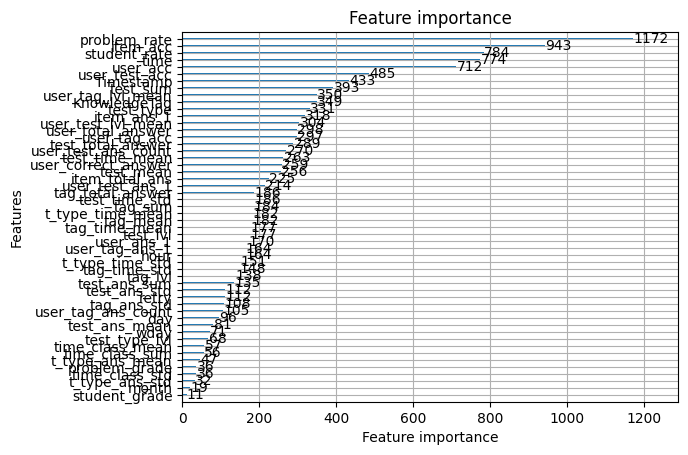

In [87]:
# INSTALL MATPLOTLIB IN ADVANCE
_ = lgb.plot_importance(model)

## 5. Inference

In [111]:
# LOAD TESTDATA
test_csv_file_path = os.path.join(data_dir, 'test_data.csv')
test_df = pd.read_csv(test_csv_file_path)

# FEATURE ENGINEERING
test_df = fe(test_df)
test_df = time_stamp_fe(test_df)
test_df = elo_fe(1,test_df)
test_df = test_fe(test_df)
test_df = tag_fe(test_df)
test_df = user_fe(test_df)

# LEAVE LAST INTERACTION ONLY
test_df = test_df[test_df['userID'] != test_df['userID'].shift(-1)]

# DROP ANSWERCODE
test_df = test_df.drop(['answerCode'], axis=1)

Timestamp feature engineering start .. Done.
TestID feature engineering start ..

/opt/conda/envs/gcn/lib/python3.10/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


 Done.
TagID feature engineering start .. Done.
UserID feature engineering start .. Done.


In [103]:
# test_df = pd.read_csv('./train+test_fe_all.csv')

In [107]:
len(test_df)

7442

In [131]:
# MAKE PREDICTION
total_preds = model.predict(test_df[FEATS])
total_preds.mean()

[LightGBM] [Fatal] The number of features in data (58) is not the same as it was in training data (30).
You can set ``predict_disable_shape_check=true`` to discard this error, but please be aware what you are doing.


LightGBMError: The number of features in data (58) is not the same as it was in training data (30).
You can set ``predict_disable_shape_check=true`` to discard this error, but please be aware what you are doing.

In [117]:
# SAVE OUTPUT
output_dir = 'output/'
now = time.localtime()
now_date = time.strftime('%Y%m%d', now)
now_hour = time.strftime('%X', now)
save_time = now_date + '_' + now_hour.replace(':', '')

fname = '{}_{}_{}_{}.csv'.format(save_time,"LGBM",auc.round(4),acc.round(4))
write_path = os.path.join(output_dir, fname)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
with open(write_path, 'w', encoding='utf8') as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(total_preds):
        w.write('{},{}\n'.format(id,p))

writing prediction : output/20230522_144746_LGBM_0.8056_0.7359.csv
